### University of Bari Aldo Moro
Master Degree in <b>Computer Science</b><br>
<b>Machine Learning Course</b> Case Study
## RNNs for Bitcoin Price Predictions
Francesco Peragine - f.peragine@studenti.uniba.it

- [ReadMe](#readme)
- [Setup](#setup)
- [Arguments](#arguments)
- [Collection](#collection)
- [Preprocessing](#preprocessing)
- [Normalization](#normalization)
- [Splitting](#splitting)
- [Model](#model)
    - [Optimization](#optimization)
- [Prediction](#prediction)
    - [Inverting](#inverting)
    - [Results](#results)

<a name='readme'></a>
## ReadMe

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

Multivariate sequence-to-sequence model based on the Encoder-Decoder architecture with attention mechanism.<br>

The notebook is set up to run:
- grid search optimization defined in the [optimization](#optimization) cell.
- results of optimizations and [prediction](#prediction) are shown in the [results](#results) cell.

All the variables, both for diagnostics and for prediction, are to be set in the [arguments](#arguments) cell.

Hope you'll enjoy the work!<br>
Francesco Peragine

<a name='setup'></a>
## Setup

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [251]:
import numpy as np
import pandas as pd
import time, math
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from datetime import timedelta

from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

from keras import backend as K, initializers, regularizers
from keras.layers import *
from keras.models import Sequential
from keras.callbacks import EarlyStopping
from keras.regularizers import l1, l2
from keras.metrics import RootMeanSquaredError

<a name='arguments'></a>
## Arguments
Diagnostics variables of [optimization](#optimization) and prediction.

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [252]:
#General variables.

DEBUG = False # if True will print name and arguments of the mail functions/methods

# fixed over all diagnostics rounds
TEST_SET_SIZE = 0.3
VALIDATION_SET_SIZE = 0.25

# time window
INPUT_STEPS = 10 # timesteps
OUTPUT_STEPS = 5 # predictions

In [253]:
# Diagnostics variables.

DIAGNOSTICS_ROUNDS = 2 # number of test batches to perform for every configuration
LRS = [0.001]
UNITS = [10, 15, 20, 30, 60]
DROPOUTS = [0.1, 0.2, 0.3, 0.4] 
BATCH_SIZES = [64, 128, 256]
L1S = [0, 1e-06, 1e-05, 1e-04, 1e-03]
L2S = [0, 1e-06, 1e-05, 1e-04, 1e-03]

# plot colors
COLORS = {
    'val_loss': 'orange',
    'val_mse': 'green',
    'val_root_mean_squared_error': 'pink',
    'loss': 'red',
    'mse': 'blue',
    'root_mean_squared_error': 'black',    
}

In [254]:
# Prediction variables
    
prediction = {
    'learning_rate': LRS[0],
    'units': UNITS[0],
    'dropout': DROPOUTS[0],
    'batch_size': BATCH_SIZES[0]
}

<a name='collection'></a>
## Collection

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [255]:
print('Data is being loaded.')

file = "src/BTC.csv"
df = pd.read_csv(file ,sep=';', encoding= 'unicode_escape', parse_dates=True)

df_backup = df.copy()

Data is being loaded.


In [256]:
df

,Date,Open,High,Low,Close,Volume_BTC,Volume_Currency,Weighted Price,Trend_date,Trend
0,13/09/2011,5.80,6.00,5.65,5.97,58.37,3.461000e+02,5.93,2011/09,1
1,14/09/2011,5.58,5.72,5.52,5.53,61.15,3.418500e+02,5.59,2011/09,1
2,15/09/2011,5.12,5.24,5.00,5.13,80.14,4.082600e+02,5.09,2011/09,1
3,16/09/2011,4.82,4.87,4.80,4.85,39.91,1.937600e+02,4.85,2011/09,1
4,17/09/2011,4.87,4.87,4.87,4.87,0.30,1.460000e+00,4.87,2011/09,1
...,...,...,...,...,...,...,...,...,...,...
3909,17/06/2022,20387.66,21325.06,20220.16,20440.70,3615.10,7.471761e+07,20668.22,2022/06,47
3910,18/06/2022,20428.19,20758.00,17592.78,18956.80,7958.39,1.503322e+08,18889.78,2022/06,47
3911,19/06/2022,18952.14,20783.48,17930.70,20552.82,5100.88,9.885419e+07,19379.82,2022/06,47
3912,20/06/2022,20557.20,21036.89,19616.10,20555.44,5112.85,1.040376e+08,20348.25,2022/06,47


In [257]:
df_backup.dtypes

Date                object
Open               float64
High               float64
Low                float64
Close              float64
Volume_BTC         float64
Volume_Currency    float64
Weighted Price     float64
Trend_date          object
Trend                int64
dtype: object

In [258]:

df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df.sort_values(by=['Date'])

df = df.set_index('Date')

<AxesSubplot:xlabel='Date'>

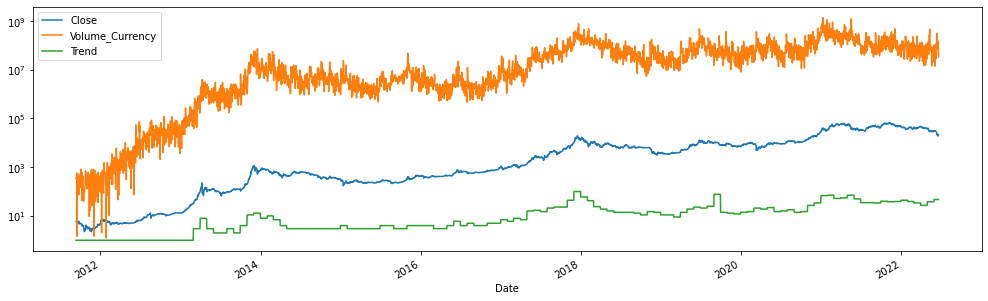

In [259]:
df.plot(y=['Close','Volume_Currency','Trend'], figsize=(17,5), logy=True)

<a name='preprocessing'></a>
## Preprocessing
Feature selection and extraction

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [260]:
df = df.drop(columns=['Open','High', 'Low', 'Volume_BTC', 'Trend_date', 'Weighted Price'])
df['Trend'] = df['Trend'].astype(float)

df

,Close,Volume_Currency,Trend
Date,,,
2011-09-13,5.97,3.461000e+02,1.0
2011-09-14,5.53,3.418500e+02,1.0
2011-09-15,5.13,4.082600e+02,1.0
2011-09-16,4.85,1.937600e+02,1.0
2011-09-17,4.87,1.460000e+00,1.0
...,...,...,...
2022-06-17,20440.70,7.471761e+07,47.0
2022-06-18,18956.80,1.503322e+08,47.0
2022-06-19,20552.82,9.885419e+07,47.0


In [261]:
df.dtypes

Close              float64
Volume_Currency    float64
Trend              float64
dtype: object

In [262]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Close,3914.0,9.024222e+03,1.515044e+04,2.24,2.611525e+02,1.026820e+03,9.252460e+03,6.755900e+04
Volume_Currency,3914.0,5.366100e+07,9.636377e+07,1.23,1.958658e+06,1.301201e+07,6.878388e+07,1.369434e+09
Trend,3914.0,1.581783e+01,1.853127e+01,1.00,3.000000e+00,9.000000e+00,2.100000e+01,1.000000e+02


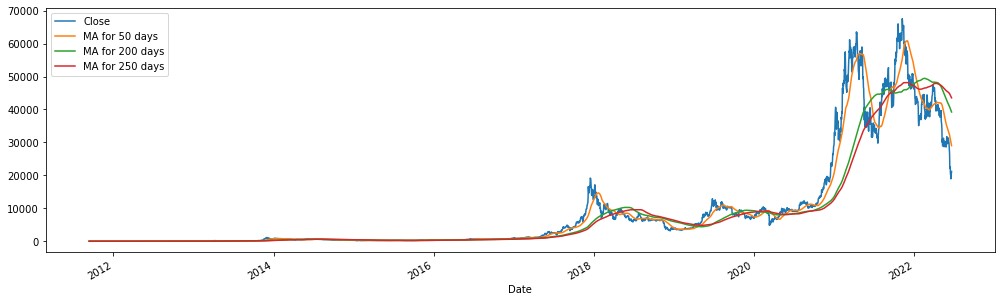

In [263]:
# Moving Averages are being considered as features

df_ma = df.copy()
ma_day = [50, 200, 250]
features = ['Close']
for ma in ma_day:
    column_name = f"MA for {ma} days"
    df_ma[column_name] = df_ma['Close'].rolling(ma).mean()
    df_ma[column_name] = df_ma[column_name].fillna(0)
#     df[column_name] = df_ma[column_name]
    features.append(column_name)
df_ma.plot(y=features, figsize=(17,5))
plt.show()

In [264]:
# Testing on smaller dataframe, to drop the first samples (prices were too low before 2014)
df = df.loc['2016-01-01':]

In [265]:
dataset = df.values
dataset = dataset.astype('float32')
dataset

array([[4.3382001e+02, 1.6405779e+06, 4.0000000e+00],
       [4.3354999e+02, 1.2877734e+06, 4.0000000e+00],
       [4.3104001e+02, 1.9591526e+06, 4.0000000e+00],
       ...,
       [2.0552820e+04, 9.8854192e+07, 4.7000000e+01],
       [2.0555439e+04, 1.0403757e+08, 4.7000000e+01],
       [2.1191410e+04, 3.3307674e+07, 4.7000000e+01]], dtype=float32)

<a name='normalization'></a>
## Normalization
The data has been scaled before the train/test splitting considering the new max heights reached in the last few months that would be otherwise been present only in the test set, heavily altering  the results.

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [266]:
# Data normalization - Scales each feature in a [0, 1]  range
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_dataset = scaler.fit_transform(dataset)
print("Data has been normalized in range (0, 1).")

Data has been normalized in range (0, 1).


<a name='splitting'></a>
## Splitting
Split data into train, validation and test sets. The test set size is the overall percentage declared in TEST_SET_SIZE, 
whilst the VALIDATION_SET_SIZE indicates the ratio with respect to the train size.
The data is NOT shuffled being a sequence type.

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [267]:
train_no_val, test = train_test_split(scaled_dataset, test_size = TEST_SET_SIZE, shuffle=False)
train, validation = train_test_split(train_no_val, test_size = VALIDATION_SET_SIZE, shuffle=False)

print("Dataset has been split:\nTrain {}\nValidation {}\nTest {}". format(train.shape, validation.shape, test.shape))

Dataset has been split:
Train (1240, 3)
Validation (414, 3)
Test (710, 3)


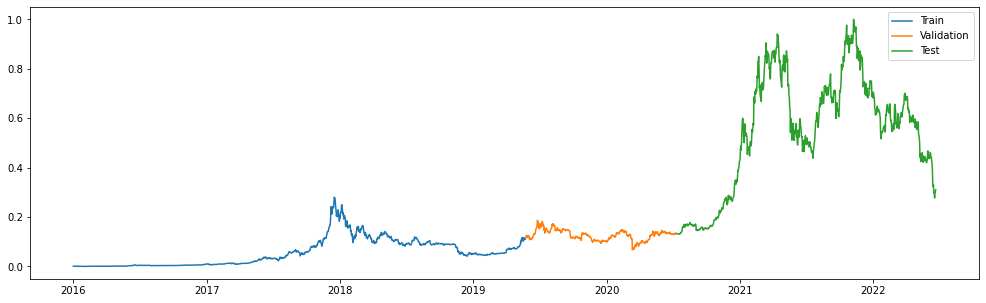

In [268]:
plt.figure(figsize=(17,5))
plt.plot(df.index[:train.shape[0]],train[:,0])
plt.plot(df.index[train.shape[0]:train.shape[0] + validation.shape[0]], validation[:,0])
plt.plot(df.index[-test.shape[0]:],test[:,0])
plt.legend(['Train', 'Validation', 'Test'])
plt.show()

<a name='model'></a>
## Model
The first GRU layer implements the encoder model. The memory cells in this layer define the length of the fixed-sized vector.<br />
The encoder produces a 2D output with length = units.<br />
The decoder is a second GRU layer that expects a 3D input to produce a decoded sequence with different lenght.
To fill the gap, a RepeatVector layer is used as an adapter to fit the 2D output of the encoder to the different length and 3D input of the decoder.<br />
The TimeDistributed wrapper allows the same output layer to be reused for each element in the output sequence.

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [269]:
class Attention(Layer):
    
    def __init__(self, return_sequences=True):
        self.return_sequences = return_sequences
        super(Attention,self).__init__()
        
    def build(self, input_shape):
        # input_shape format (none, output_timesteps, units*2)
        if DEBUG:
            print("input shape", input_shape)
        self.W=self.add_weight(name="att_weight", shape=(input_shape[-1],1), initializer="normal")
        self.b=self.add_weight(name="att_bias", shape=(input_shape[1],1), initializer="zeros")
        super(Attention,self).build(input_shape)
        
    def call(self, x): 
        # Alignment scores. Pass them through tanh function
        e = K.tanh(K.dot(x,self.W)+self.b)
        
        # Compute the weights
        a = K.softmax(e, axis=1)
        
        # Compute the context vector
        context_vector = x*a
        if DEBUG:
            print("x{}\ne{}\na{}\ncontext_vector{}".format(x.shape, e.shape, a.shape, context_vector.shape))
        
        if self.return_sequences:
            return context_vector
        
        return K.sum(output, axis=1)

In [270]:
class EncoderDecoder(): 
    learning_rate = 0.01
    units = 15
    feature_size = 1
    input_steps = 1
    output_steps = 1
    dropout = 0.0
    batch_size = 32
    l1 = 0
    l2 = 0
    epochs = 300
    loss_func = 'mae'
    activation = 'tanh'
    metrics = [
        'mse',
#         RootMeanSquaredError()
    ]
    model = None
    history = None
    evaluation = None
    verbose = 0
    train = None,
    validate = False,
    validation = None,
    test = None
        
    def __init__(self, **kwargs):
        if DEBUG: print("EncoderDecoder Constructor\n",kwargs)
        try:
            for key, value in kwargs.items():
                if DEBUG: print(key, value)
                setattr(self, key, value)
        except Exception:
            return None
        self.optimizer = RMSprop(learning_rate = self.learning_rate)
        
    # Convertig to supervised learning by adopting the timeframe approach.
    # Splits the @dataset into a sequence of timesteps
    # Returns a sequence ready to fit the GRU layer [samples, timesteps, features]

    def create_sequence(self, dataset):
        if DEBUG:
            print("EncoderDecoder create_sequence")
            print("dataset shape",dataset.shape)
            print("dataset\n",dataset)
        X, Y = [], []
        for i in range(len(dataset)):
            # find the end of this pattern
            last_index = i + self.input_steps
            last_index_output = last_index + self.output_steps
            # check if we are beyond the dataset
            if last_index_output <= len(dataset):
            # gather input and output parts of the pattern
                X.append(dataset[i:last_index, :])
                Y.append(dataset[last_index:last_index_output, :])
        return np.array(X), np.array(Y)         
    
    def unfold_sequence(self, X):
        if DEBUG: 
            print("EncoderDecoder unfold_sequence")
            print("X shape",X.shape)
            print("X\n",X)
        dataset = []
        #first row of each timestep
        for i in range(X.shape[0]):
            dataset.append(X[i,0])
        # each row of the last timestep but the first one
        for i in range(X.shape[1]):
            dataset.append(X[-1,-i+1,:]) 
        return np.array(dataset)

    def builder(self):
        if DEBUG: 
            print("EncoderDecoder builder")
            
        X_train_seq, Y_train_seq = self.create_sequence(self.train)
        
        if self.validate is True:
            X_val_seq, Y_val_seq = self.create_sequence(self.validation)
 
        self.model = Sequential()
    
        # Encoder
        encoder_layer = Bidirectional(
            GRU(units = self.units,
#                 dropout = self.dropout,
                input_shape  = (self.input_steps, self.feature_size),
                kernel_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2),
                bias_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2),
                name = 'encoder_gru_layer',
               ),
            name = 'bidirectional_encoder_layer'
        )
       
        # Context
        repeat_layer = RepeatVector(
            self.output_steps,
            name = 'repeat_vector_layer'
        )
        
        # Attention
        attention_layer = Attention(return_sequences = True)

        # Decoder
        decoder_layer = GRU(
            units = self.units,
            return_sequences = True,
#             dropout = self.dropout,
            kernel_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2),
            bias_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2),
            name = 'decoder_gru_layer',
        )
        dropout = Dropout(self.dropout)
        # Output
        output_layer = TimeDistributed(
            Dense(
                self.feature_size,
                activation = 'relu',
                kernel_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2),
                bias_regularizer=regularizers.l1_l2(l1=self.l1, l2=self.l2),
                name='dense_layer'
            ),
            name='time_distributed_layer'
        )
        
        self.model = Sequential([encoder_layer,
                                 dropout,
                                 repeat_layer,
#                                  attention_layer,
                                 decoder_layer,
                                 dropout,
                                 output_layer])
        
        self.model.compile(loss = self.loss_func, optimizer = self.optimizer, metrics=self.metrics)

        # Callback
        es = EarlyStopping(monitor = 'loss', mode = 'min', patience = 5, verbose = self.verbose)
        
        if self.validate is True:
            self.history = self.model.fit(X_train_seq,
                                          Y_train_seq,
                                          validation_data =(X_val_seq, Y_val_seq),
                                          callbacks=[es], 
                                          batch_size = self.batch_size,
                                          epochs = self.epochs,
                                          verbose = self.verbose,
                                          shuffle=False)
        else:
            self.history = self.model.fit(X_train_seq,
                                          Y_train_seq,
                                          callbacks=[es], 
                                          batch_size = self.batch_size,
                                          epochs = self.epochs,
                                          verbose = self.verbose,
                                          shuffle=False)
        if DEBUG:
            print(self.history)
    
    def evaluator(self):
        if DEBUG:
            print("EncoderDecoder evaluator")
            print("test shape", self.test.shape)
            print("test\n", self.test)
        X_test_seq, Y_test_seq = self.create_sequence(self.test)
        self.evaluation = self.model.evaluate(X_test_seq, Y_test_seq, verbose=self.verbose)
        
    def prediction(self, data_seq):
        if DEBUG:
            print("EncoderDecoder prediction")
            print("data_seq shape", data_seq.shape)
            print("data_seq\n", data_seq)
        return self.model.predict(data_seq)

In [271]:
def avg_list(l):
    return sum(l)/len(l)

In [272]:
def start(**kwargs):
    if DEBUG:
        print("init kwargs\n",kwargs)

    # Start timer
    start_time = time.clock()
    
    # Setting some arguments
    encoderDecoder = EncoderDecoder(**kwargs)
    
    # Compile, Fit & Evaluate
    encoderDecoder.builder()
    encoderDecoder.evaluator()

    # Stop timer
    end_time = time.clock()
    time_delta = end_time - start_time
       
    return encoderDecoder, time_delta

<a name='optimization'></a>
## Optimization
Diagnostics based on multiple runs. Set [arguments](#arguments) before starting.

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [273]:
def optimize():
    if DEBUG: 
        print("Optimize")
    
    print("Overall averages over {} trials, {} inputs {} outputs". format(DIAGNOSTICS_ROUNDS, INPUT_STEPS, OUTPUT_STEPS))
    print("Validation ratio {} Test ratio {}".format(VALIDATION_SET_SIZE, TEST_SET_SIZE))

    for lr in LRS:
        for unit in UNITS:
            for dropout in DROPOUTS:
                for l1 in L1S:
                    for l2 in L2S:
                        for batch_size in BATCH_SIZES:
                            avg_metrics = {
                                'val_loss' : [],
                                'val_mse' : [],
#                                 'val_root_mean_squared_error': [],
                                'loss' : [],
                                'mse' : [],
#                                 'root_mean_squared_error': [],
                                'eval_loss': [],
                                'eval_mse': [],
                            }
                            time_total = 0

                            fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,4))

                            # Multiple runs for diagnostics
                            for i in range(DIAGNOSTICS_ROUNDS):
                                model, time_delta = start(
                                    train = train,
                                    validate = True,
                                    validation = validation,
                                    test = test,
                                    learning_rate = lr,
                                    units = unit,
                                    dropout = dropout,
                                    batch_size = batch_size,
                                    l1 = l1,
                                    l2 = l2,
                                    input_steps = INPUT_STEPS,
                                    output_steps = OUTPUT_STEPS,
                                    feature_size = dataset.shape[1]
                                )
                                time_total += int(time_delta)

                                avg_metrics['eval_loss'].append(model.evaluation[0])
                                avg_metrics['eval_mse'].append(model.evaluation[1])
                                
                                #['val_loss', 'val_mse', 'val_root_mean_squared_error', 'loss', 'mse', 'root_mean_squared_error'])
                                
                                for metric in model.history.history:
                                    if "eval_" in metric: continue
                                    metric_history = model.history.history[metric]
                                    avg_metric = avg_list(metric_history)
                                    avg_metrics[metric].append(avg_metric)
                                    ax1.plot(metric_history, label = metric, color=COLORS[metric]) 

                            ax1.set_title("Train-Validation Learning Curves")
                            ax1.legend([
                                'val_loss',
                                'val_mse',
#                                 'val_root_mean_squared_error',
                                'loss',
                                'mse',
#                                 'root_mean_squared_error',
                            ])

                            ax2.plot(avg_metrics['eval_loss'], label = "loss")
                            ax2.plot(avg_metrics['eval_mse'], label = "mse")
                            ax2.set_title("Tests evaluations")
                            ax2.legend()
                            plt.show()

                            # Summary
                            print("\nLr {}, Units {}, Dropout {}, Batch size {}, l1 {}, l2 {}, {} seconds\n"
                                  .format(lr, unit, dropout, batch_size, l1, l2, time_total))

                            for metric in avg_metrics:    
                                print(metric, avg_list(avg_metrics[metric]))

<a name='prediction'></a>
# Prediction
Making predictions on the whole dataset.

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [274]:
def predict(model, scaled_dataset):
    if DEBUG: 
        print("predict")
        print("scaled_dataset shape",scaled_dataset.shape)
        print("scaled_dataset\n",scaled_dataset)
    X_seq, Y_seq = model.create_sequence(scaled_dataset)
    prediction = model.prediction(X_seq), Y_seq
    return prediction

In [275]:
def plot_predict(rescaled_X, rescaled_Y):
    keys = df.keys()
    for i in range(len(keys)):
        plt.figure(figsize=(15,5))
        plt.plot(df.index[-rescaled_X.shape[0]:], rescaled_X[:,i], label="Prediction")
        plt.plot(df.index[-rescaled_Y.shape[0]:], rescaled_Y[:,i], label="Observed")
        plt.title(keys[i])
        plt.yscale('log')
        plt.legend()
        plt.show()

<a name='inverting'></a>
### Inverting
Unfold the sequences and inverting the results from their scaled version.

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

In [276]:
def invert(model, predicted_X, Y_seq):
    if DEBUG:
        print("Invert")
        print("predicted X {} Y_seq {}".format(predicted_X, Y_seq))
    unfolded_X = model.unfold_sequence(predicted_X)
    rescaled_X = scaler.inverse_transform(unfolded_X)
    unfolded_Y = model.unfold_sequence(Y_seq)
    rescaled_Y = scaler.inverse_transform(unfolded_Y)
    return rescaled_X, rescaled_Y

<a name='results'></a>
### Results
Once the parameters have been tested, we can build the model with the most performant configuration and predict the outputs.

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)

Overall averages over 2 trials, 10 inputs 5 outputs
Validation ratio 0.25 Test ratio 0.3


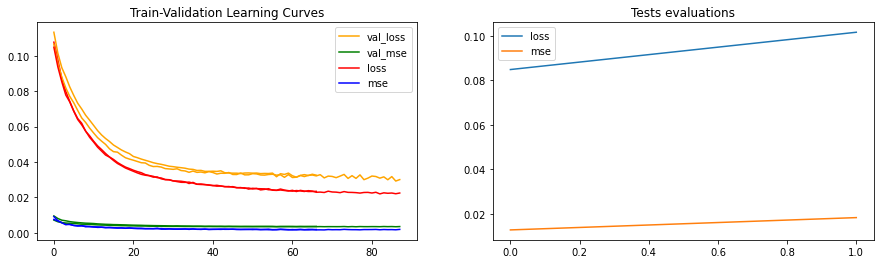


Lr 0.001, Units 20, Dropout 0.3, Batch size 128, l1 0, l2 0.001, 53 seconds

val_loss 0.04249334123679037
val_mse 0.004063520977282113
loss 0.034852166681054994
mse 0.002482802196881441
eval_loss 0.09326173669134064
eval_mse 0.015543487388640642


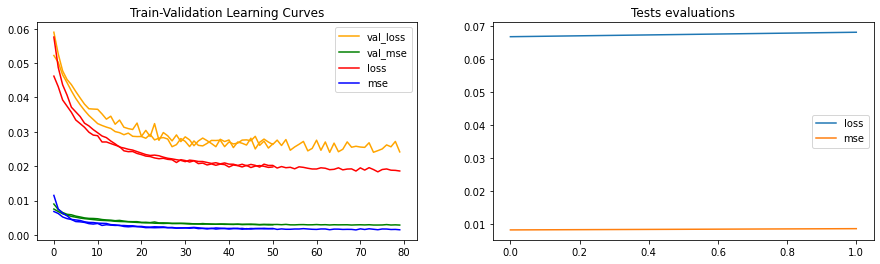


Lr 0.001, Units 20, Dropout 0.3, Batch size 128, l1 0, l2 0.0001, 47 seconds

val_loss 0.030167129268600403
val_mse 0.003732194646270763
loss 0.024167816931290262
mse 0.0025411016839772104
eval_loss 0.06750319482780051
eval_mse 0.008424048312008381


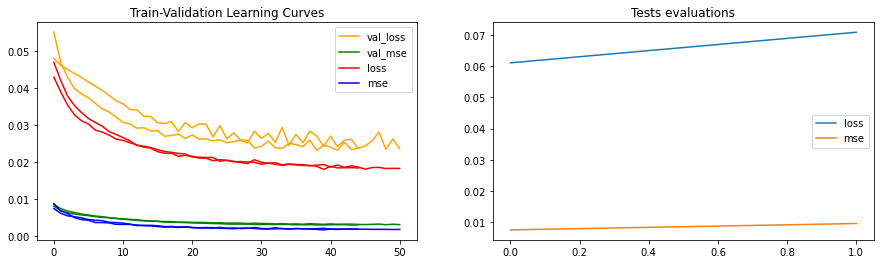


Lr 0.001, Units 20, Dropout 0.3, Batch size 128, l1 0, l2 1e-05, 37 seconds

val_loss 0.029743091192851276
val_mse 0.003908682711805929
loss 0.02318742589614145
mse 0.0026943679165484665
eval_loss 0.06597325332120232
eval_mse 0.00851802108809352


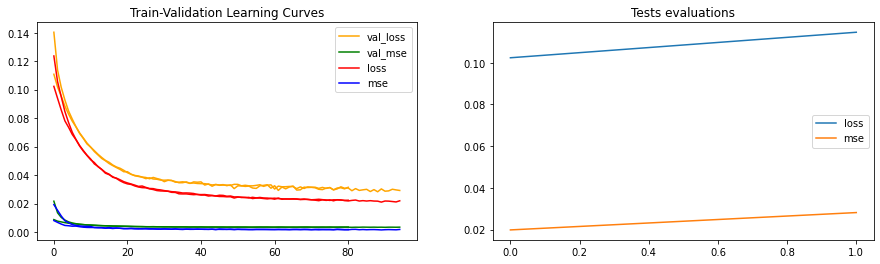


Lr 0.001, Units 20, Dropout 0.3, Batch size 128, l1 1e-06, l2 0.001, 61 seconds

val_loss 0.04107155892949811
val_mse 0.004083754047339926
loss 0.03301212871697587
mse 0.0025434341823184154
eval_loss 0.10854518490618673
eval_mse 0.02398187480866909


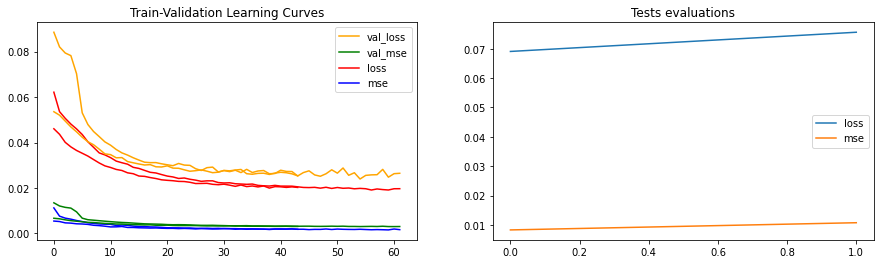


Lr 0.001, Units 20, Dropout 0.3, Batch size 128, l1 1e-06, l2 0.0001, 41 seconds

val_loss 0.03298481816947568
val_mse 0.004119568614151241
loss 0.02614718723576128
mse 0.0027156203979325187
eval_loss 0.07235156875317808
eval_mse 0.009508440736681223


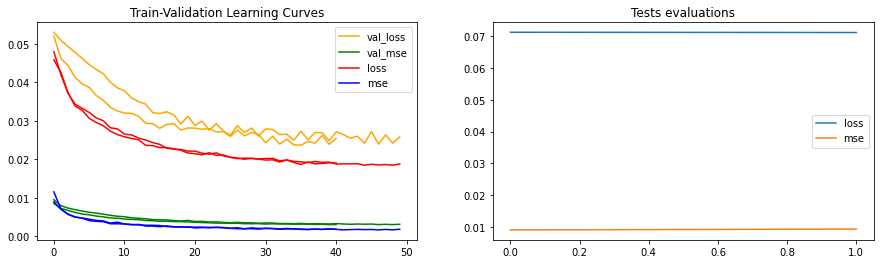


Lr 0.001, Units 20, Dropout 0.3, Batch size 128, l1 1e-06, l2 1e-05, 38 seconds

val_loss 0.030952659291028972
val_mse 0.0041537945808433905
loss 0.02382461301226539
mse 0.0028208706731817166
eval_loss 0.07129223818152115
eval_mse 0.009155516978353262


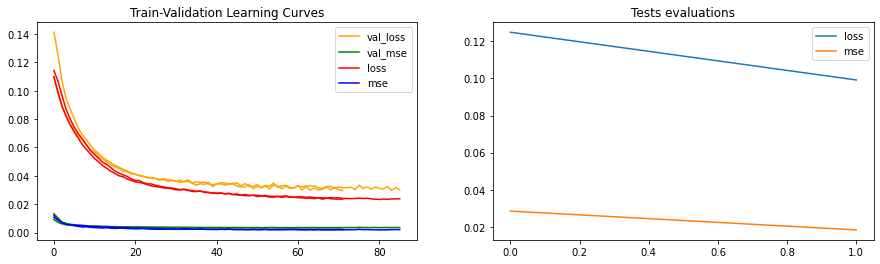


Lr 0.001, Units 20, Dropout 0.4, Batch size 128, l1 0, l2 0.001, 61 seconds

val_loss 0.04223654684485525
val_mse 0.003982611359522716
loss 0.0361823414463644
mse 0.0029195331334512745
eval_loss 0.11203406571314253
eval_mse 0.02338131796568632


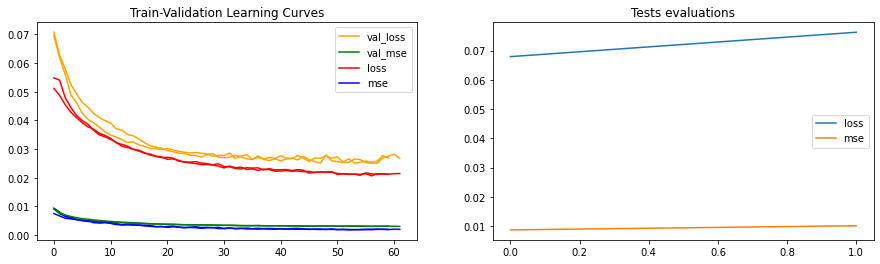


Lr 0.001, Units 20, Dropout 0.4, Batch size 128, l1 0, l2 0.0001, 47 seconds

val_loss 0.031712036712665946
val_mse 0.003914738102735932
loss 0.027268499916776066
mse 0.003024868996656169
eval_loss 0.0720722376657971
eval_mse 0.009429026395082474


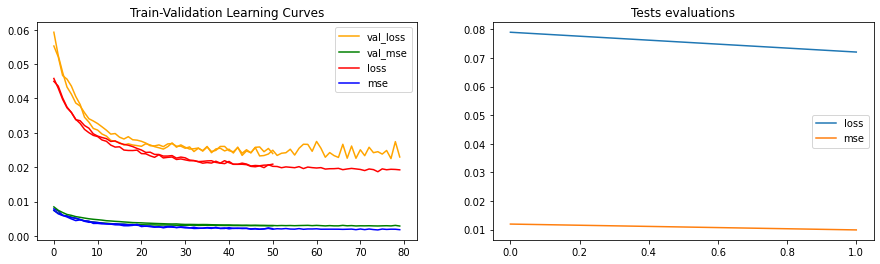


Lr 0.001, Units 20, Dropout 0.4, Batch size 128, l1 0, l2 1e-05, 48 seconds

val_loss 0.02846882653545918
val_mse 0.0036309745005222364
loss 0.024563341479389572
mse 0.002917144842207313
eval_loss 0.07556151311801768
eval_mse 0.010895664803683758


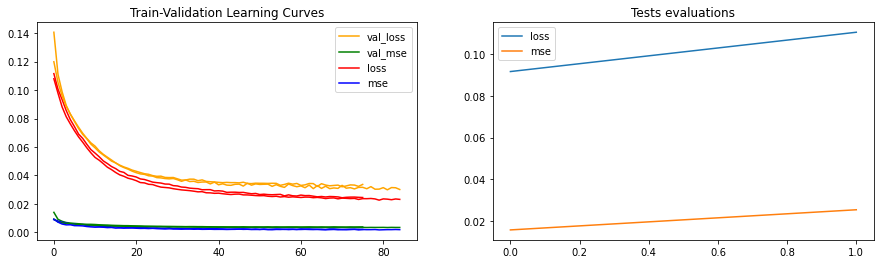


Lr 0.001, Units 20, Dropout 0.4, Batch size 128, l1 1e-06, l2 0.001, 57 seconds

val_loss 0.043031921169077614
val_mse 0.004337505574627194
loss 0.03622682212410416
mse 0.0029632330244809286
eval_loss 0.10109489385423989
eval_mse 0.0204759668558836


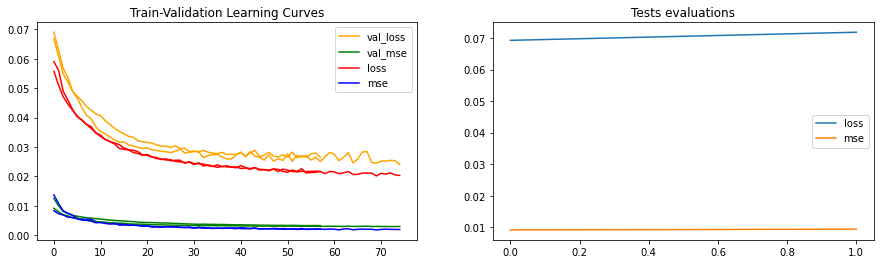


Lr 0.001, Units 20, Dropout 0.4, Batch size 128, l1 1e-06, l2 0.0001, 49 seconds

val_loss 0.03193855358229458
val_mse 0.00408650679088294
loss 0.02726681495915815
mse 0.003212339481279982
eval_loss 0.07051969555088844
eval_mse 0.009310246910899878


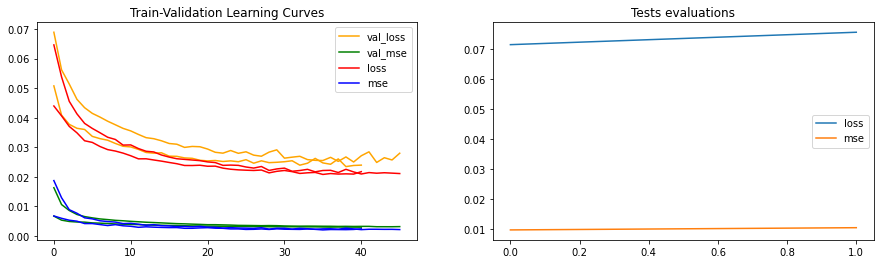


Lr 0.001, Units 20, Dropout 0.4, Batch size 128, l1 1e-06, l2 1e-05, 34 seconds

val_loss 0.030300347423032798
val_mse 0.004062410372419012
loss 0.026565343491423442
mse 0.003423695399797268
eval_loss 0.0736901731198204
eval_mse 0.010061809793114662


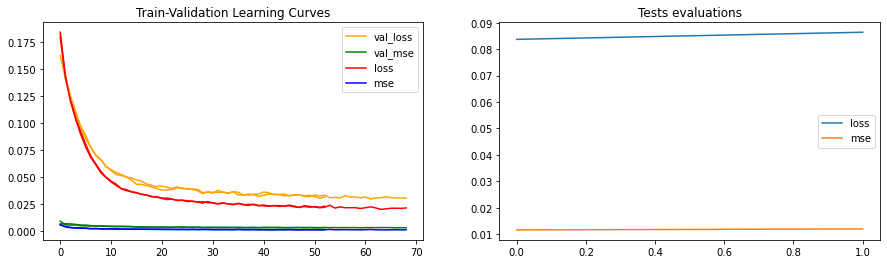


Lr 0.001, Units 60, Dropout 0.3, Batch size 128, l1 0, l2 0.001, 46 seconds

val_loss 0.04783538004478689
val_mse 0.003972844286147675
loss 0.03853240775648939
mse 0.0018777289280236492
eval_loss 0.08508800432599824
eval_mse 0.011767649557441473


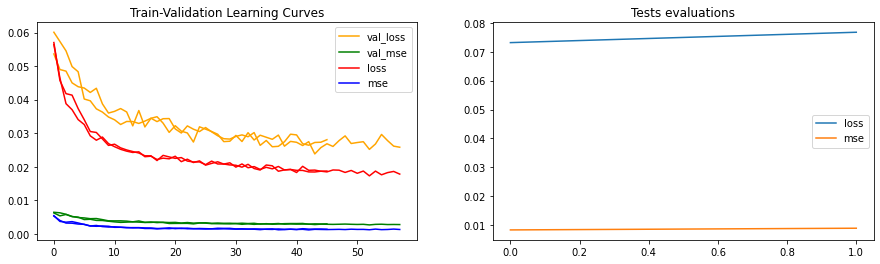


Lr 0.001, Units 60, Dropout 0.3, Batch size 128, l1 0, l2 0.0001, 40 seconds

val_loss 0.03275033299223347
val_mse 0.0034584749073405907
loss 0.02387269558337876
mse 0.0017940723758736819
eval_loss 0.07497681116406946
eval_mse 0.00857586320489645


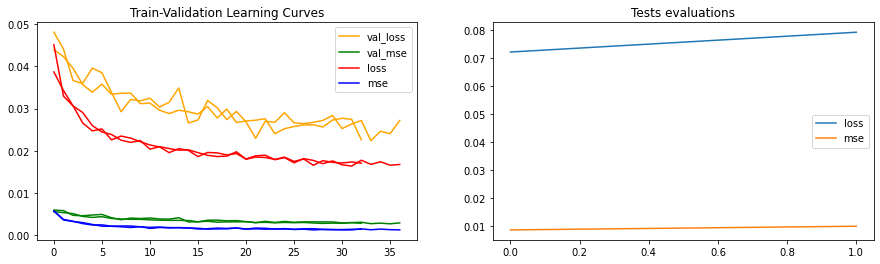


Lr 0.001, Units 60, Dropout 0.3, Batch size 128, l1 0, l2 1e-05, 30 seconds

val_loss 0.030157495162752592
val_mse 0.003633659718658113
loss 0.02108961220525
mse 0.0019616237019679152
eval_loss 0.07578694901760968
eval_mse 0.009386473335325718


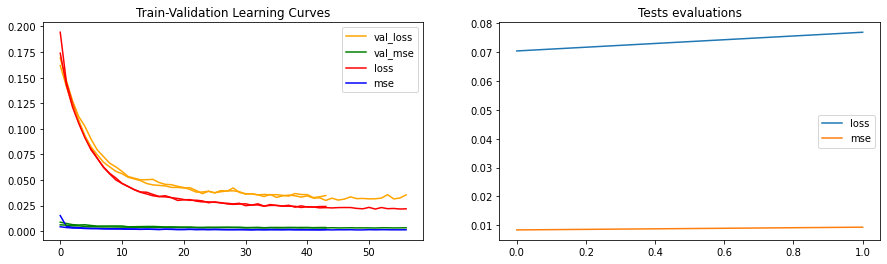


Lr 0.001, Units 60, Dropout 0.3, Batch size 128, l1 1e-06, l2 0.001, 39 seconds

val_loss 0.051536625503477734
val_mse 0.00409345431604231
loss 0.04234490514979583
mse 0.0020783322023957863
eval_loss 0.07369896105822477
eval_mse 0.00883105956017971


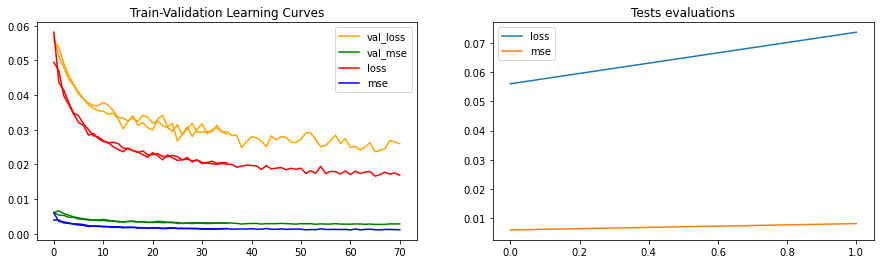


Lr 0.001, Units 60, Dropout 0.3, Batch size 128, l1 1e-06, l2 0.0001, 43 seconds

val_loss 0.03289172108304077
val_mse 0.003524564934469226
loss 0.02445755861555273
mse 0.0018497027412079877
eval_loss 0.06478959527508966
eval_mse 0.007091415347531438


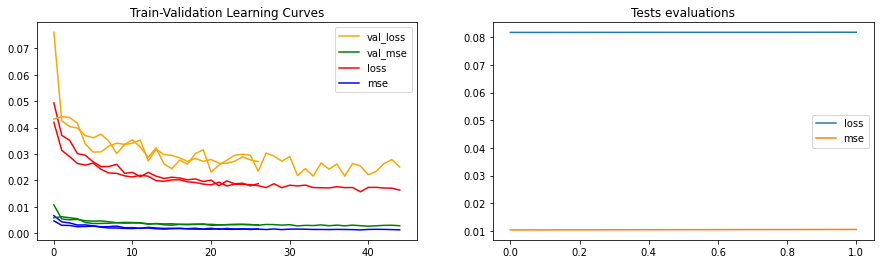


Lr 0.001, Units 60, Dropout 0.3, Batch size 128, l1 1e-06, l2 1e-05, 30 seconds

val_loss 0.03122623221714188
val_mse 0.0037744165967322062
loss 0.022236608763315242
mse 0.0020404972282617733
eval_loss 0.08181830371419588
eval_mse 0.010416612029075623


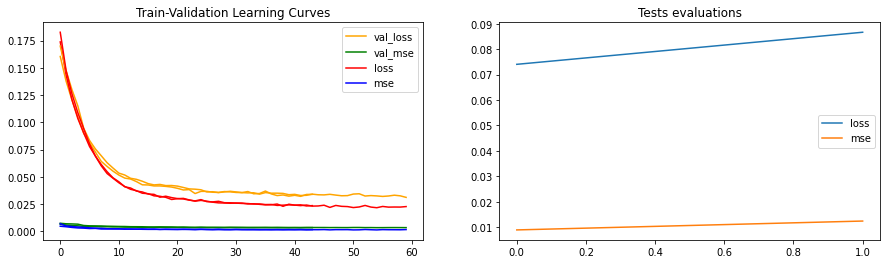


Lr 0.001, Units 60, Dropout 0.4, Batch size 128, l1 0, l2 0.001, 42 seconds

val_loss 0.04925701616755264
val_mse 0.0039721113881872345
loss 0.04115316215699766
mse 0.0020579867908963934
eval_loss 0.08033064714279668
eval_mse 0.01064633158966899


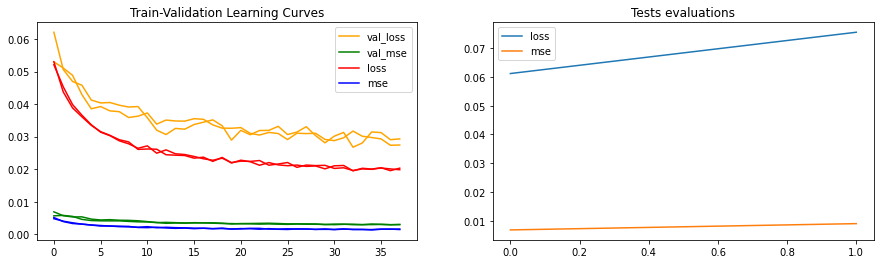


Lr 0.001, Units 60, Dropout 0.4, Batch size 128, l1 0, l2 0.0001, 32 seconds

val_loss 0.034638152034267
val_mse 0.00363188531972762
loss 0.025496226650333034
mse 0.002027507712084212
eval_loss 0.06840459903937647
eval_mse 0.007882795762270689


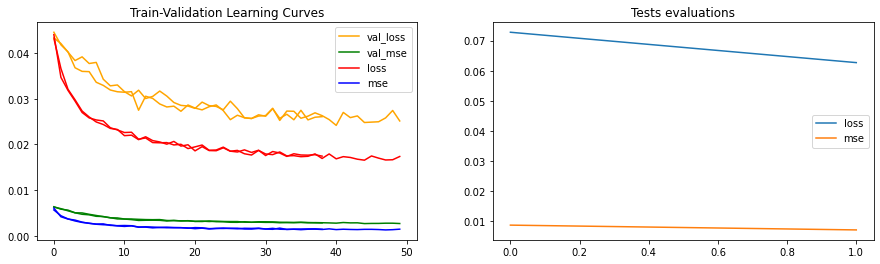


Lr 0.001, Units 60, Dropout 0.4, Batch size 128, l1 0, l2 1e-05, 37 seconds

val_loss 0.029812134063664154
val_mse 0.003521521743446684
loss 0.02118893419090926
mse 0.0020143113336645257
eval_loss 0.06774766319270792
eval_mse 0.00791962444782257


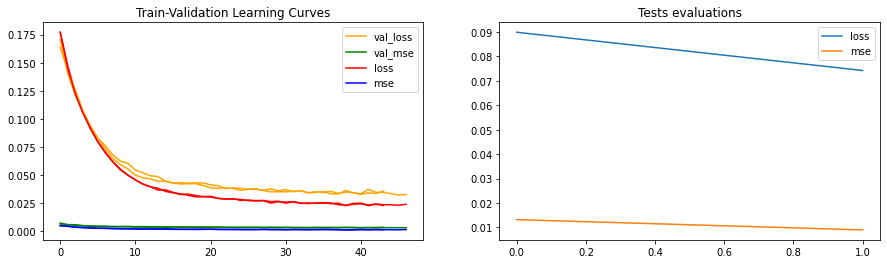


Lr 0.001, Units 60, Dropout 0.4, Batch size 128, l1 1e-06, l2 0.001, 37 seconds

val_loss 0.051659082171563016
val_mse 0.0039943885870482344
loss 0.04372628156252824
mse 0.002144839787535771
eval_loss 0.08203713724325443
eval_mse 0.01109290448948741


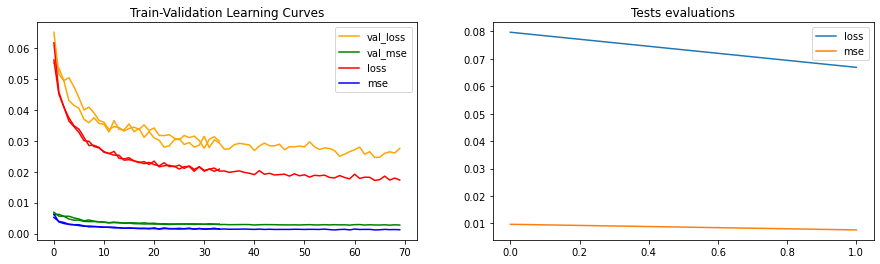


Lr 0.001, Units 60, Dropout 0.4, Batch size 128, l1 1e-06, l2 0.0001, 41 seconds

val_loss 0.033687605950339636
val_mse 0.0034886130216891464
loss 0.024667596358510006
mse 0.0018880221525113248
eval_loss 0.07331096667839193
eval_mse 0.00866203405894339


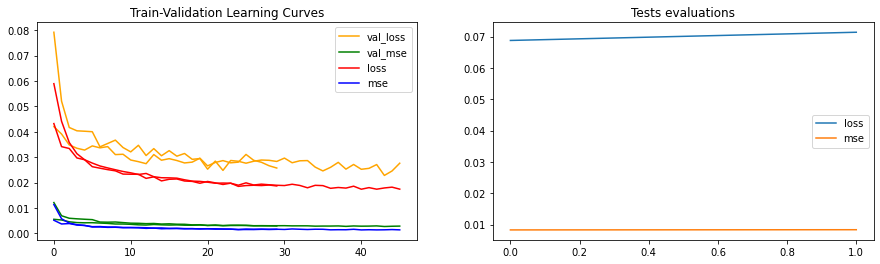


Lr 0.001, Units 60, Dropout 0.4, Batch size 128, l1 1e-06, l2 1e-05, 34 seconds

val_loss 0.03099621612864776
val_mse 0.0036660537427372257
loss 0.022940297717546528
mse 0.0022096516076893806
eval_loss 0.07007150214979019
eval_mse 0.00830948119983077


In [277]:
# Runs the validation rounds

optimize()

Model: "sequential_158"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_encoder_layer  (None, 40)                2880      
_________________________________________________________________
dropout_79 (Dropout)         multiple                  0         
_________________________________________________________________
repeat_vector_layer (RepeatV (None, 5, 40)             0         
_________________________________________________________________
decoder_gru_layer (GRU)      (None, 5, 20)             3660      
_________________________________________________________________
time_distributed_layer (Time (None, 5, 3)              63        
Total params: 6,603
Trainable params: 6,603
Non-trainable params: 0
_________________________________________________________________


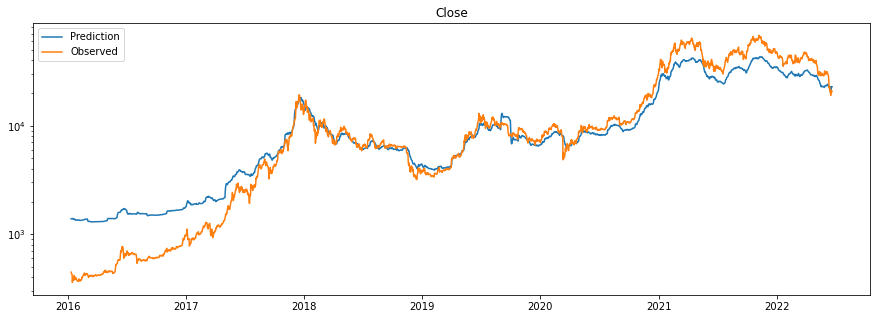

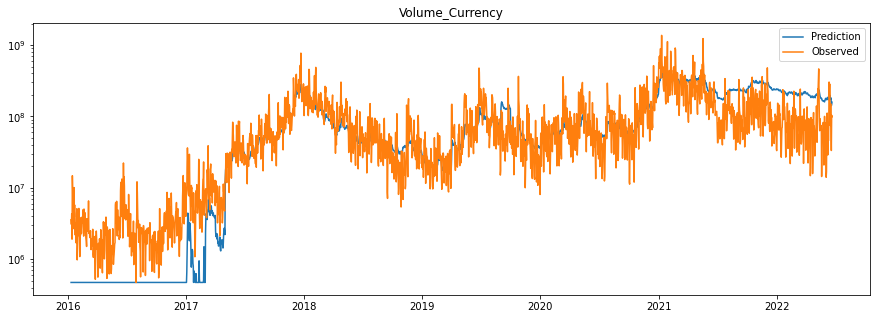

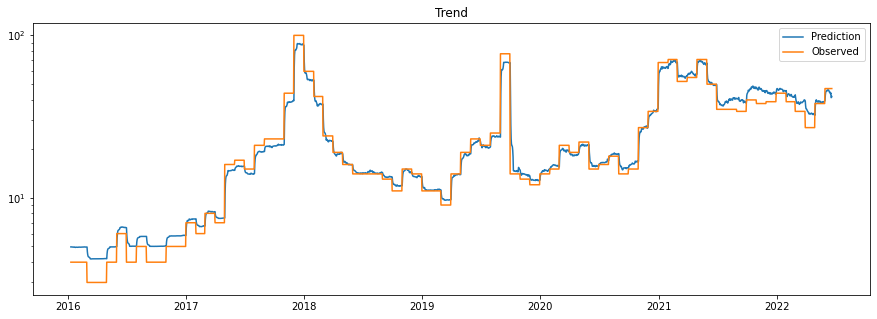

In [278]:
# Trains on the full train set and performs the prediction

model, _ = start(
    train = train_no_val,
    test = test,
    learning_rate = prediction['learning_rate'],
    units = prediction['units'],
    dropout = prediction['dropout'],
    batch_size = prediction['batch_size'],
    input_steps = INPUT_STEPS,
    output_steps = OUTPUT_STEPS,
    feature_size = dataset.shape[1]
)

model.model.summary()

prediction, Y_seq = predict(model, scaled_dataset)
rescaled_X, rescaled_Y = invert(model, prediction, Y_seq)
plot_predict(rescaled_X, rescaled_Y)

[toMenu](#RNNs-for-Bitcoin-Price-Predictions)